In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import h5py
from load_data import voxelize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image

def visualize_multiple_voxels(voxels, num_samples=8):
    """
    Visualizes multiple voxel grids in a single row.
    
    Parameters:
    voxels (numpy.ndarray): Array of voxel grids
    num_samples (int): Number of samples to visualize
    """
    # Randomly select samples
    total_samples = voxels.shape[0]
    selected_indices = np.random.choice(total_samples, num_samples, replace=False)
    selected_voxels = voxels[selected_indices]
    
    # Create a figure with subplots in one row
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4), 
                            subplot_kw={'projection': '3d'})
    plt.tight_layout(pad=3.0)  # Increase spacing between subplots
    
    # Plot each voxel grid
    for i, (ax, voxel) in enumerate(zip(axes, selected_voxels)):
        # Get occupied voxels
        occupied_voxels = np.argwhere(voxel == 1)
        
        # Plot occupied voxels
        ax.scatter(occupied_voxels[:, 0], 
                  occupied_voxels[:, 2], 
                  occupied_voxels[:, 1], 
                  s=1)  # Smaller point size
        
        # Set labels and title
        ax.set_title(f'Sample {i+1}')
        
        # Remove tick labels for cleaner look
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        # Set equal aspect ratio
        ax.set_box_aspect([1, 1, 1])
        
        # Set consistent view angle
        ax.view_init(elev=30, azim=45)
        
        # Set limits
        ax.set_xlim([0, voxel.shape[0]])
        ax.set_ylim([0, voxel.shape[1]])
        ax.set_zlim([0, voxel.shape[2]])

    # Save figure
    plt.savefig('multiple_samples.png', dpi=300, bbox_inches='tight')
    plt.close()

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    import matplotlib.pyplot as plt
    import numpy as np
    from io import BytesIO
    from PIL import Image

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add grid lines
    ax.grid(True)

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])

    # Adjust axis visibility and ticks
    ax.axis("on")  # Enable axes visibility
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Save to buffer
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()

    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# load the preprocessed voxel data.
voxels = np.load("./samples/S_32_airplane/airplane_final_samples.npy")
print(voxels.shape)
visualize_multiple_voxels(voxels)
# print(voxels)

(1000, 64, 64, 64)


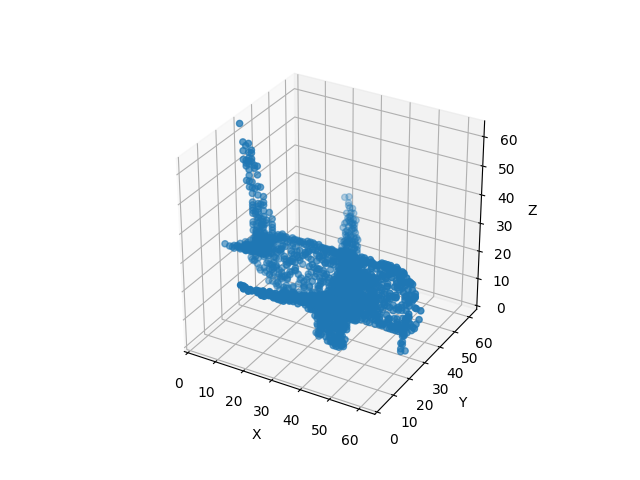

In [ ]:
img = visualize_voxel(voxels[0].squeeze())
display(img)

torch.Size([1, 64, 64, 64])


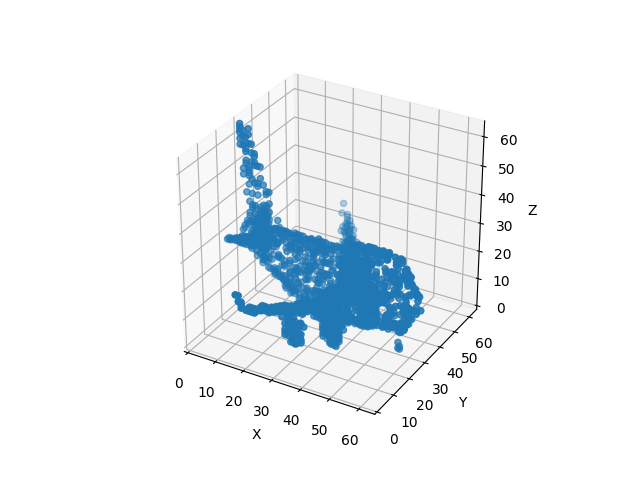

tensor(1749)
torch.Size([1, 32, 32, 32])
tensor(992)


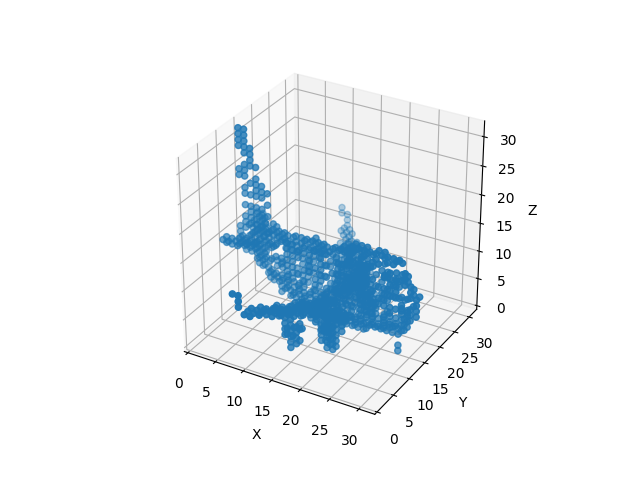

torch.Size([1, 1, 64, 64, 64])
tensor(7946)


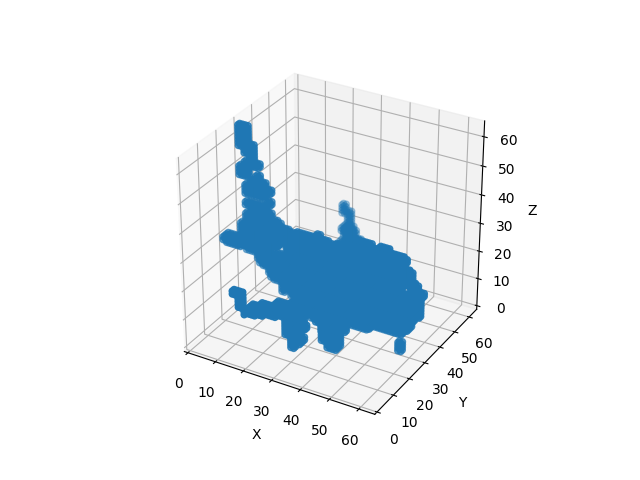

In [14]:
from models.voxel_processor import VoxelProcessor

x = torch.from_numpy(voxels[3]).unsqueeze(dim=0)
print(x.shape)
x_img = visualize_voxel(x.squeeze().numpy())
display(x_img)

vp = VoxelProcessor(input_size=64, target_size=32)

# Load SR checkpoint
checkpoint = torch.load('checkpoints/SR/sr_airplane_epoch_v1.pt')  # Adjust epoch number
vp.sr_module.load_state_dict(checkpoint['model_state_dict'])
vp.sr_module.eval()

print(torch.sum(torch.where(x > 0.5, 1, 0)))
ds = vp.downscale(x)
print(ds.shape)
print(torch.sum(torch.where(ds > 0.5, 1, 0)))
ds_img = visualize_voxel(ds.squeeze().numpy())
display(ds_img)

with torch.no_grad():
   us = vp.upscale(ds.unsqueeze(dim=0))
print(us.shape)
print(torch.sum(torch.where(us > 0.5, 1, 0)))
us_img = visualize_voxel(us.squeeze().numpy())
display(us_img)
